In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import pandas as pd
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from functools import partial
from utils import optimizer as opt
from plotly.subplots import make_subplots
import pickle
from tqdm.notebook import tqdm
import statsmodels.api as sm
from scipy.signal import find_peaks
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import (
    distance_weighted,
    generate_subsequences,
    reconstructed_loss,
    normalize_lambda,
)

### Preprocessing

In [2]:
train_data = pd.read_csv('data/swat/SWaT_test.csv')

In [3]:
train_data["Normal/Attack"] = train_data["Normal/Attack"].replace({"Normal": 0, "Attack": 1})
train_data["Normal/Attack"].value_counts()
df_np_label = train_data.drop([" Timestamp", "Normal/Attack"], axis=1).values
train_data = train_data.loc[:, (train_data != train_data.iloc[0]).any()].copy() # remove constant columns


#test
train_data = train_data.iloc[:].copy()


data_np = train_data.drop(columns = ["Unnamed: 0","Normal/Attack", " Timestamp"]).values

In [4]:
scaler = StandardScaler()
data_np = scaler.fit_transform(data_np)

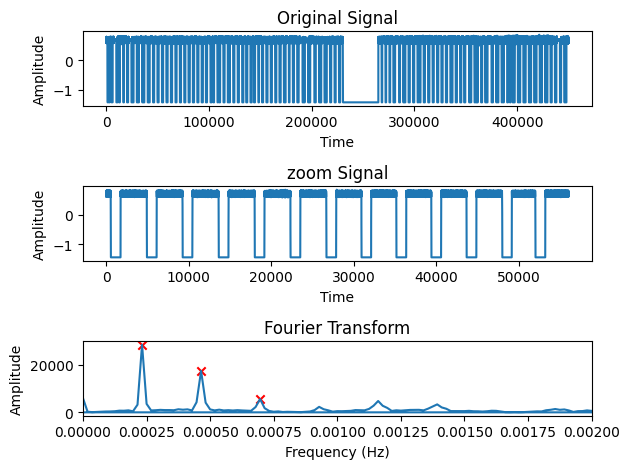

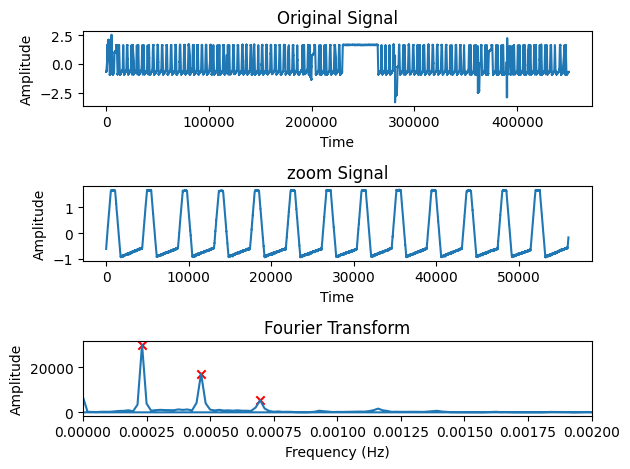

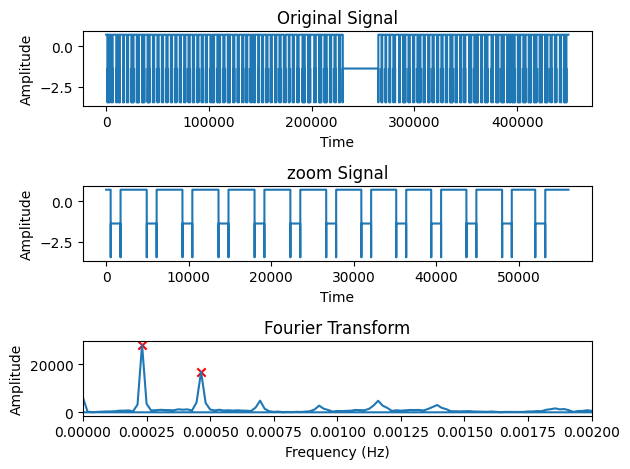

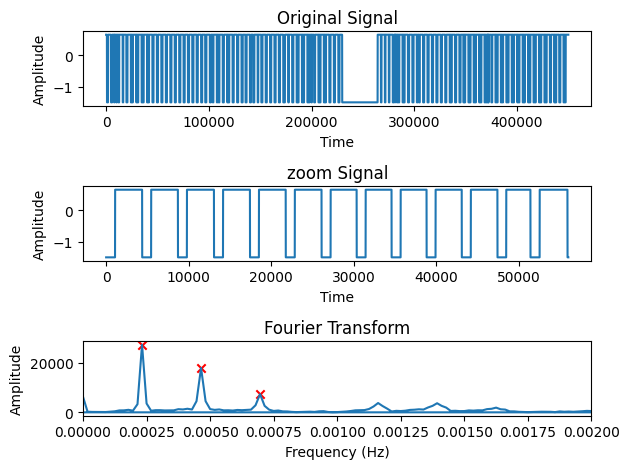

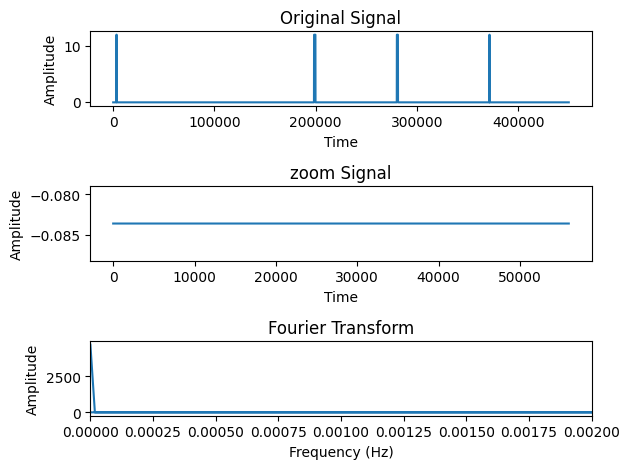

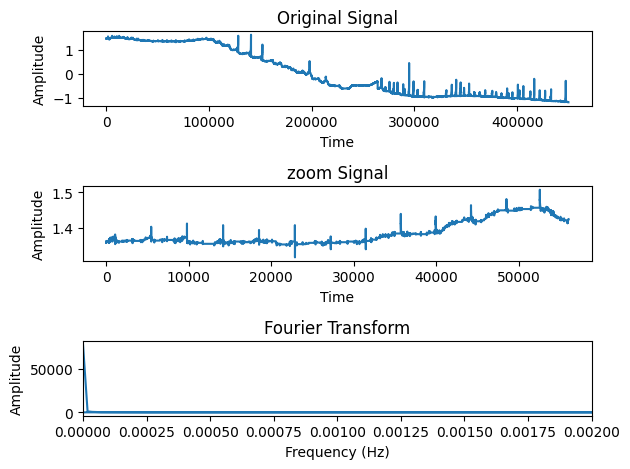

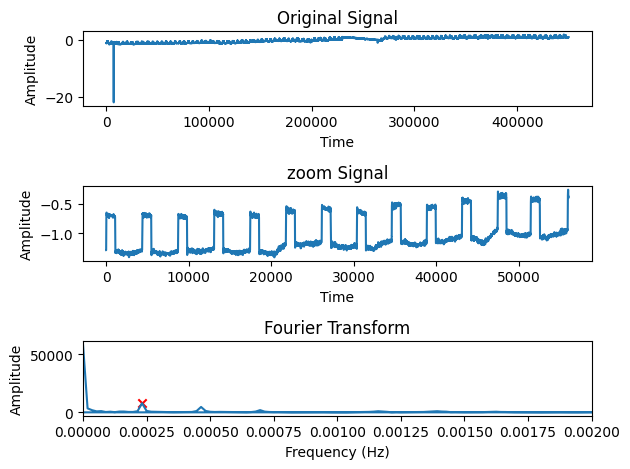

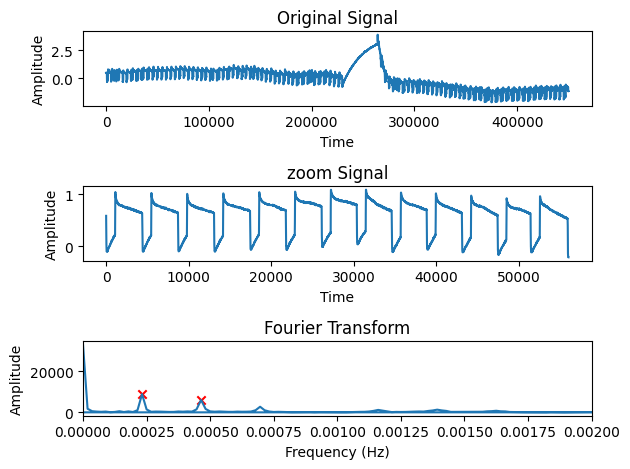

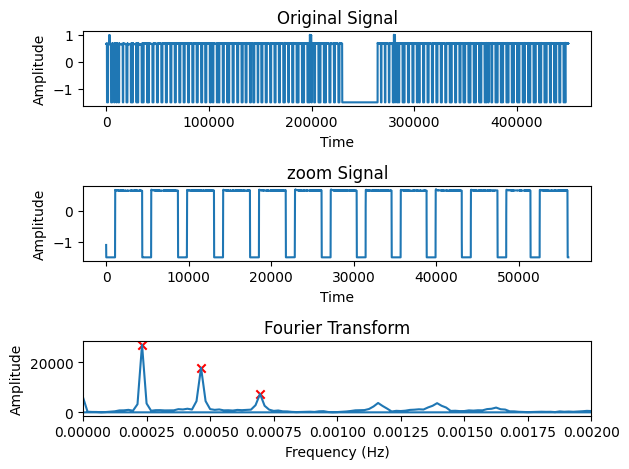

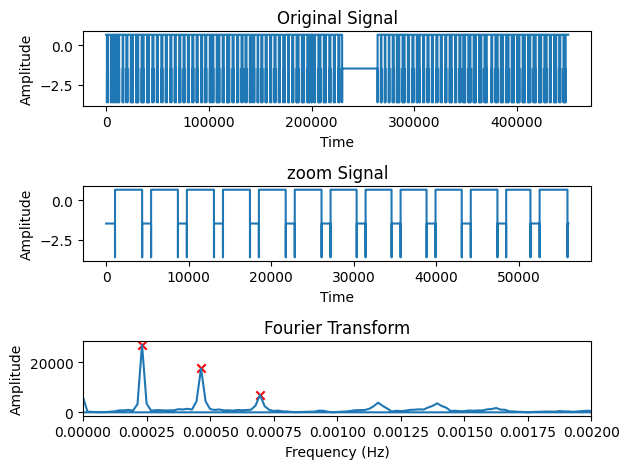

In [5]:
n_components = 10
periodicity = []
for i in range(n_components):
    signal_periodic = data_np[45000:101000, i]
    fourier_transform = np.fft.fft(signal_periodic)
    frequencies = np.fft.fftfreq(len(signal_periodic), 1)
    peaks, _ = find_peaks(np.abs(fourier_transform), height=0.5e4)
    periodicity.append(1/frequencies[peaks[:3]])
    plt.subplot(3, 1, 1)
    plt.plot(data_np[:, i])
    plt.title('Original Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 2)
    plt.plot( signal_periodic)
    plt.title('zoom Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(3, 1, 3)
    plt.plot(frequencies, np.abs(fourier_transform))
    plt.scatter(frequencies[peaks], np.abs(fourier_transform)[peaks], color='red', marker='x', label='Local Maxima')

    plt.title('Fourier Transform')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0,0.002)
    plt.tight_layout()
    plt.show()


In [6]:
main_periodicity = periodicity[0][0]
print("Main periodicity in seconds", main_periodicity)
downsampling_rate = int(main_periodicity/40)

Main periodicity in seconds 4307.692307692308


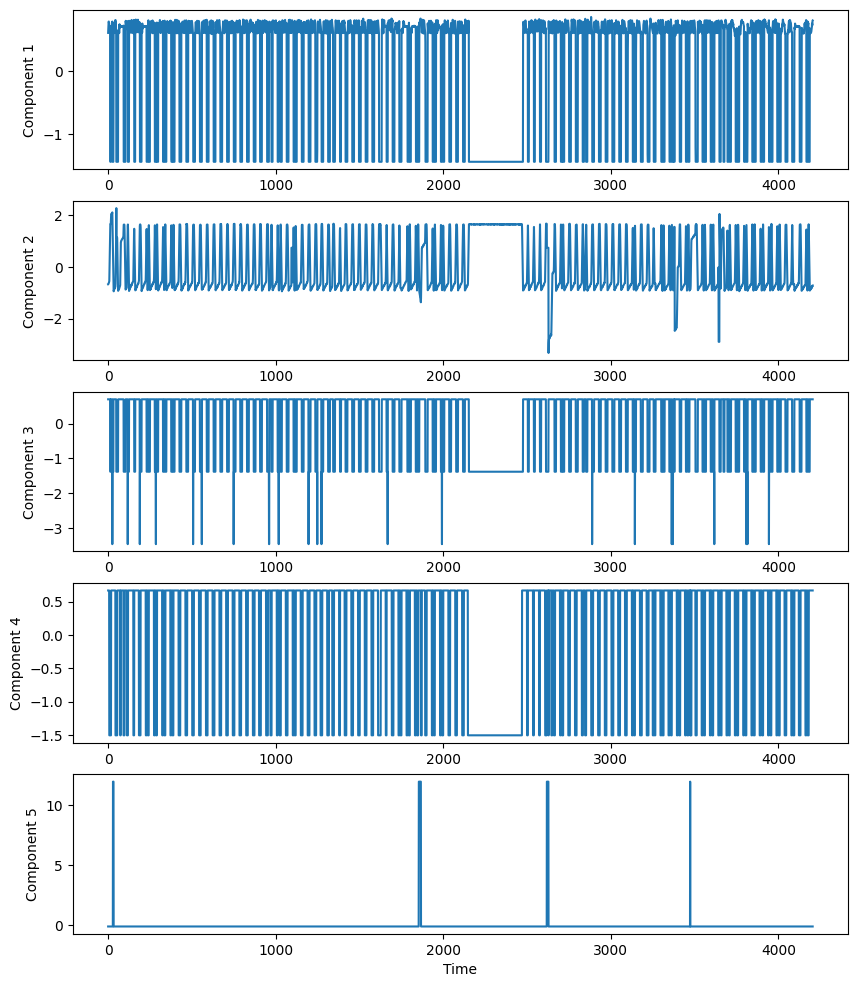

In [7]:
### Downsample the data 

# Plot the first 5 components in 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 12))

for i in range(5):
    axes[i].plot(data_np[::downsampling_rate, i])
    axes[i].set_ylabel(f'Component {i+1}')

plt.xlabel('Time')
plt.show()

### Anomaly detection

#### Generate subsequences for shapes and amplitudes

In [8]:
# data_pca_reduced = data_pca[:,:n_components]

window_size = int(main_periodicity/downsampling_rate)

stride =int(window_size/5)
sequences = generate_subsequences(data_np[::downsampling_rate], window_size, stride)
label_sequences = generate_subsequences(train_data["Normal/Attack"].values.reshape(-1,1)[::downsampling_rate], window_size, stride)

print("window size = ", window_size)
print("stride = ", stride)

window size =  40
stride =  8


In [9]:
sequences_acf = np.zeros_like(sequences)
sequences_copy = sequences.copy()

for i in range(sequences_copy.shape[0]):
    for j in range(sequences_copy.shape[2]):

        # check if all values are the same
        if np.all(sequences_copy[i, :, j] == sequences_copy[i, 0, j]):
            sequences_copy[i, 0, j] += 0.0001
            # print("warning: constant timeseries")
            
        sequences_acf[i, :, j] = sm.tsa.acf(
            sequences_copy[i, :, j], nlags=len(sequences_copy[i, :, j]) - 1
        )

In [10]:
data_for_clustering = sequences.reshape(sequences.shape[0], -1)
data_for_clustering_shapes = sequences_acf.reshape(sequences_acf.shape[0], -1)

#### Baseline clustering PCA :

In [11]:
pca = PCA()

data_pca = pca.fit_transform(data_np[::downsampling_rate])

# Calculate the reconstruction error
reconstructed_data = pca.inverse_transform(data_pca)
reconstruction_error = np.linalg.norm(data_pca - reconstructed_data, axis=1) 

In [12]:
idx = np.where(train_data[::downsampling_rate]["Normal/Attack"]  == 1)[0]

In [13]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=np.arange(len(reconstruction_error)),
        y=reconstruction_error,
        mode="lines",
        name="Loss",
    )
)
fig.add_trace(
    go.Scatter(
        x=idx, y=reconstruction_error[idx], mode="markers", name="Attack"
    )
)

fig.update_layout(title="PCA Reconstruction Error", xaxis_title="Time", yaxis_title="Reconstruction Error")

#### Fuzzy C-Means on amplitude using naive mu

In [23]:
def run_fuzzy_naive(data, N_cluster, N_fuzzy_coef=2):
    mu = [1 / data.shape[1] for i in range(data.shape[1] // window_size)]
    mu = np.repeat(mu, window_size)

    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        data.T,
        N_cluster,  # N cluster
        N_fuzzy_coef,  # fuzzy coef
        metric=partial(distance_weighted, mu=mu),
        error=0.005,
        maxiter=1000,
        init=None,
    )

    # Reconstruction of initial points
    reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

    loss = reconstructed_loss(reconstructed_points, data)

    return loss, cntr, u, fpc

In [24]:
loss, cntr, u, fpc = run_fuzzy_naive(data_for_clustering, N_cluster=2, N_fuzzy_coef=2)

In [25]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [26]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

#### Fuzzy C-means on shapes with ACF

In [18]:
loss, cntr, u, fpc = run_fuzzy_naive(data_for_clustering_shapes, N_cluster=2, N_fuzzy_coef=2)

In [19]:
label_reshaped = np.max(label_sequences, axis=1)
# Select points with label 1
label_1_indices = np.where(label_reshaped == 1)[0]

In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(loss)), y=loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Optimization

In [39]:
N_cluster = 2
model = "amplitude"

In [60]:
if model == "amplitude":
    data_for_clustering_opt = data_for_clustering
else:
    data_for_clustering_opt = data_for_clustering_shapes

algorithm_param = {
    "max_num_iteration": 40,
    "population_size": 30,
    "mutation_probability": 0.2,
    "elit_ratio": 0.1,
    "crossover_probability": 0.5,
    "parents_portion": 0.3,
    "crossover_type": "uniform",
    "max_iteration_without_improv": None,
}

In [61]:
print(f"dimension : {data_for_clustering_opt.shape[1] // window_size}")

dimension : 44


In [62]:
optimizer = opt(
    N_cluster=N_cluster,
    data=data_for_clustering_opt,
    window_size=window_size,
    ga_opt_parameters=algorithm_param,
)

In [64]:
# optimizer.run_ga()

In [65]:
optimizer.run_pso(max_iter=40)

  0%|          | 0/40 [00:00<?, ?it/s]

In [69]:
fitness_pso = optimizer.fitness_pso
solution_pso = optimizer.solution_pso

print(f"pso: {fitness_pso}")

pso: 9283.904137207248


In [45]:
# convergence_ga = optimizer.convergence_ga
# solution_ga = optimizer.solution_ga
# fitness_pso = optimizer.fitness_pso
# solution_pso = optimizer.solution_pso

# print(f"ga: {convergence_ga[-1]}, pso : {fitness_pso}")

ga: 9564.610594961316, pso : 9250.823499483953


In [67]:
# print(f"ga: {normalize_lambda(solution_ga['variable'])}, \n pso : {normalize_lambda(solution_pso)}")

In [68]:
# print(len(optimizer.dict_opt_save), len(optimizer.dict_opt_save_pso))

In [71]:
fig = go.Figure()

# fig.add_trace(
#     go.Scatter(
#         y=[
#             optimizer.dict_opt_save[i]["loss_sum"]
#             for i in range(0, len(optimizer.dict_opt_save_pso))
#         ],
#         name="GA",
#     )
# )

fig.add_trace(
    go.Scatter(
        y=[
            optimizer.dict_opt_save_pso[i]["loss_sum"]
            for i in range(0, len(optimizer.dict_opt_save_pso))
        ],
        name="pso",
    )
)

fig.update_layout(title="Loss")

In [349]:
# with open(f'shape_{N_cluster}_dict_opt_save_NOPCA_STD.pkl', 'wb') as f:
#     pickle.dump(optimizer.dict_opt_save, f)

# with open(f'shape_{N_cluster}_dict_opt_save_pso_NOPCA_STD.pkl', 'wb') as f:
#     pickle.dump(optimizer.dict_opt_save_pso, f)

In [109]:
# optimizer.dict_opt_save
# optimizer.dict_opt_save_pso

### Use the optimization result to run the reconstruction loss

In [ ]:
# use stored mu : 
# optimizer.dict_opt_save_pso[len(optimizer.dict_opt_save_pso)-1]["mu"]

opt_mu = solution_ga["variable"] # solution_pso

In [ ]:
win_len = data_for_clustering_opt.shape[1] // len(opt_mu)

opt_mu = opt_mu / opt_mu.sum()  # normalize the coefficients
opt_mu = np.repeat(opt_mu, win_len)

In [ ]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data_for_clustering_opt.T,
    N_cluster, # N cluster
    2,
    metric=partial(distance_weighted, mu=opt_mu),
    error=0.005,
    maxiter=1000,
    init=None,
)

# Reconstruction of initial points
opt_reconstructed_points = np.dot(u.T, cntr) / np.sum(u, axis=0)[:, None]

In [ ]:
opt_loss = reconstructed_loss(opt_reconstructed_points, data_for_clustering_opt)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(len(opt_loss)), y=opt_loss, mode="lines", name="Loss"))
fig.add_trace(
    go.Scatter(
        x=label_1_indices, y=opt_loss[label_1_indices], mode="markers", name="Attack"
    )
)

fig

### Metric : combining the subsequences to calculate a score on the og TS

In [313]:
def upscale_signal(subsequences, original_size, stride, window_length, operator=np.maximum):
    upscaled_signal = np.zeros(original_size)  # Initialize upscaled signal array

    for i, subsequence in enumerate(subsequences):
        start_index = i * stride
        end_index = start_index + window_length
        upscaled_signal[start_index:end_index] = operator(upscaled_signal[start_index:end_index], subsequence)

    return upscaled_signal[upscaled_signal > 0]

data_pca_reduced_downsampled = data_np[::downsampling_rate].copy()
total_loss = upscale_signal(opt_loss, data_pca_reduced_downsampled.shape[0], stride, window_size, operator=np.maximum)

In [314]:
fig = go.Figure()

temp = np.where(train_data["Normal/Attack"][::downsampling_rate].values == 1)[0]

fig.add_trace(
    go.Scatter(
        x=np.arange(len(total_loss)), y=total_loss, mode="lines", name="opt Loss"
    )
)
fig.add_trace(go.Scatter(x=temp, y=total_loss[temp], mode="markers", name="Attack"))

fig.add_trace(
    go.Scatter(
        x=np.arange(len(total_loss)),
        y=[np.mean(total_loss)*1.1 for i in range(len(total_loss))],
        mode="lines",
        name="threshold",
    )
)

fig